In [5]:
!pip install surprise

In [14]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [15]:
user = pd.read_csv('./data/BX-CSV/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('./data/BX-CSV/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']
print(len(user))
user.head()

b'Skipping line 349637: expected 3 fields, saw 4\n'
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


501175


userID                            Location   Age
0      1                  nyc, new york, usa   NaN
1      2           stockton, california, usa  18.0
2      3     moscow, yukon territory, russia   NaN
3      4           porto, v.n.gaia, portugal  17.0
4      5  farnborough, hants, united kingdom   NaN

In [16]:
print(len(rating))
rating.head()

1149780


userID        ISBN  bookRating
0  276725  034545104X           0
1  276726  0155061224           5
2  276727  0446520802           0
3  276729  052165615X           3
4  276729  0521795028           6

In [6]:
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)
print(len(df))
df.head()


1083192


userID        ISBN  bookRating
0      2  0195153448           0
1      7   034542252           0
2      8  0002005018           5
3      8  0060973129           0
4      8  0374157065           0

In [17]:
#查看数据分布
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [18]:
# 按ISBN分组,查看数据分布
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
layout = go.Layout(title = 'Distribution Of Number of Ratings for Books (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings for Books'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [20]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
239789  0971880107        2357
45926   0316666343        1210
80952   0385504209         838
9347    0060928336         690
39708   0312195516         682
98686   044023722X         611
161832  0679781587         600
27357   0142001740         580
161567  067976402X         574
149100  0671027360         553

In [22]:
#按userId分组，查看数据分布
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))

layout = go.Layout(title = 'Distribution Of Number of Ratings for Users (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings for Users'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [23]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
4213    11676       13602
74815  198711        7550
58113  153662        6109
37356   98391        5891
13576   35859        5850
80185  212898        4785
28884   76352        3367
42037  110973        3100
88584  235105        3067
86808  230522        2991

In [24]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1083192, 3)
The new data frame shape:	(127313, 3)


In [27]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

In [29]:
benchmark = []
# 尝试所有算法
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # 在交叉验证集上的表现
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
   
    #记录结果
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [30]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

fit_time  test_rmse  test_time
Algorithm                                        
BaselineOnly       0.186389   3.388820   0.389099
CoClustering       1.868054   3.482010   0.277561
SlopeOne           0.679995   3.496178   3.088883
KNNWithMeans       0.585146   3.503492   4.197303
KNNBaseline        0.732632   3.509872   5.000202
KNNWithZScore      0.763165   3.520579   4.316255
SVD                4.641362   3.555159   0.406608
KNNBasic           0.502316   3.742535   3.861255
SVDpp            120.319417   3.813885   5.882513
NMF                5.778431   3.871185   0.470428
NormalPredictor    0.108167   4.694107   0.542749

In [31]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.11143040657043457, 0.12382221221923828, 0.12295770645141602),
 'test_rmse': array([ 3.38106758,  3.38864295,  3.39774838]),
 'test_time': (0.250734806060791, 0.2508251667022705, 0.252239465713501)}

In [32]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.4013


3.4012998276961119

In [34]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [36]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]
best_predictions

uid         iid  rui  est                    details   Iu   Ui  err
18249  185233  0553278002  0.0  0.0  {'was_impossible': False}  330   27  0.0
14891  228998  0345422317  0.0  0.0  {'was_impossible': False}  186   49  0.0
10722   55548  0316602906  0.0  0.0  {'was_impossible': False}  132   39  0.0
19271  127429  0380730847  0.0  0.0  {'was_impossible': False}  107   48  0.0
10738  196457  0140092323  0.0  0.0  {'was_impossible': False}   49   45  0.0
22377   26544  0425173534  0.0  0.0  {'was_impossible': False}  174   30  0.0
10748  195116  0971880107  0.0  0.0  {'was_impossible': False}    8  592  0.0
17622  185384  0971880107  0.0  0.0  {'was_impossible': False}   56  592  0.0
23207  145431  080410946X  0.0  0.0  {'was_impossible': False}   60   31  0.0
14127  206074  0971880107  0.0  0.0  {'was_impossible': False}   39  592  0.0

In [37]:
worst_predictions

uid         iid   rui       est                    details   Iu  \
9007   200674  0425141233  10.0  0.331709  {'was_impossible': False}  138   
691    238781  0743406184  10.0  0.251458  {'was_impossible': False}  179   
15776   85656  0061091790  10.0  0.216095  {'was_impossible': False}   47   
25822  179733  0767905202  10.0  0.160482  {'was_impossible': False}   92   
6787    69232  0440224810  10.0  0.155066  {'was_impossible': False}  129   
16369  102967  0446610399  10.0  0.153097  {'was_impossible': False}  358   
19025  124489  0452269652  10.0  0.145034  {'was_impossible': False}   48   
13796  166123  0449221504  10.0  0.057020  {'was_impossible': False}  181   
27800  238781  0345443284  10.0  0.000000  {'was_impossible': False}  179   
13080   91832  0440241537  10.0  0.000000  {'was_impossible': False}   91   

        Ui        err  
9007    43   9.668291  
691     25   9.748542  
15776   40   9.783905  
25822   39   9.839518  
6787    31   9.844934  
16369   75   9.846903  
19025   22   9.854966  
13796   87   9.942980  
27800  143  10.000000  
13080   78  10.000000

In [67]:
df_new.loc[df_new['ISBN'] == '0440241537']['bookRating'].describe()

count    100.00000
mean       1.95000
std        3.45936
min        0.00000
25%        0.00000
50%        0.00000
75%        1.25000
max       10.00000
Name: bookRating, dtype: float64

<IPython.core.display.Javascript object>


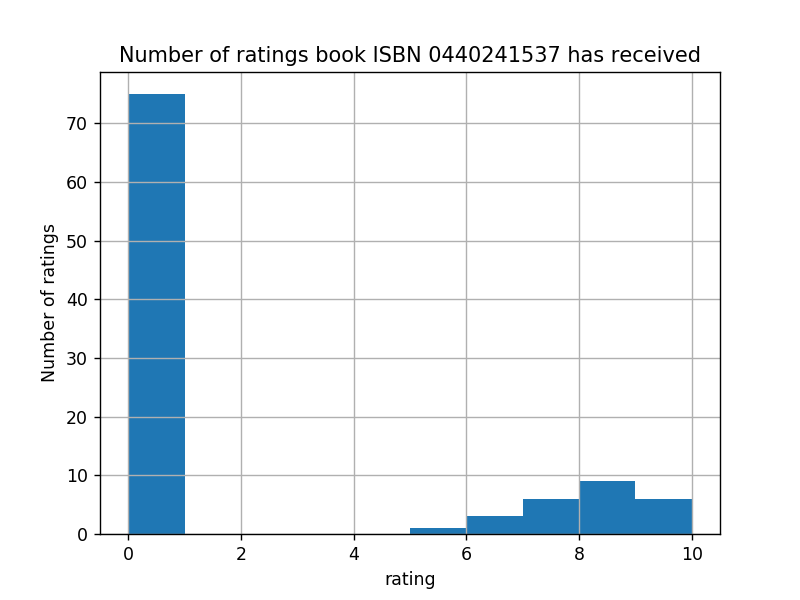

In [72]:
import matplotlib.pyplot as plt
%matplotlib notebook

df_new.loc[df_new['ISBN'] == '0440241537']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 0440241537 has received')
plt.show();

事实证明，0440241537这本书得到的大部分评分都为0，换句话说，数据中的大多数用户将0440241537本书评为0分，只有少数用户评为10。 似乎对于每个预测，都有一些特别列外的用户。